In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from PIL import Image
import pandas as pd
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score 

from preprocessing import create_csv_labels
from custom_dataset import CustomDataset
from vilbert_adapt import CustomBert

c:\Users\adrie\.conda\envs\DL_mp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
on_colab = False
create_csv = False

# step 1: preprocessing and data loading

In [6]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = 'drive/MyDrive/DL_project'
else:
    dataset_path = ''

# Load dataset
image_path = os.path.join(dataset_path, 'dataset/img_tens')
img_text_path = os.path.join(dataset_path, 'dataset/img_txt')
json_path = os.path.join(dataset_path, 'dataset/MMHS150K_GT.json')
GT_path = os.path.join(dataset_path, 'dataset/MMHS150K_Custom.csv')


In [7]:
# Create cleaned csv file
if create_csv:
    filename = os.path.join(dataset_path, "dataset/MMHS150K_Custom.csv")
    create_csv_labels(json_path, filename, img_text_path)
    GT_path = filename

In [8]:
dataset = CustomDataset(GT_path, image_path, img_text_path)


c:\Users\adrie\.conda\envs\DL_mp\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# visual inspection
dataset[1]

(tensor([  101,  1026,  5310,  1028,  1026,  5310,  1028,  6616,  3256,  2317,
         10514, 28139, 22911,  2923, 11669,  2035,  1997,  2017,  2024, 16939,
         13044,  1026, 24471,  2140,  1028,  7592,  1010,  2317,  8986,  1012,
          2204,  1011,  9061,  1012,  2500,  2097,  2085,  3796,  2017,  2302,
         11973,  2000,  5547,  2115, 16476,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [10]:

# Define hyperparameters -------------------------------------------------------

batch_size = 10

# ------------------------------------------------------------------------------

# Split dataset into training, validation, and test sets
dataset_size = len(dataset)
train_set, test_set, val_set = torch.utils.data.dataset.random_split(dataset, [0.1, 0.8, 0.1])

# Create data loader for training set
not_hate_indices = []
hate_indices = []
for idx in range(len(train_set)):
    print(f"{idx}/{len(train_set)}")
    if train_set[idx][3] == 1:
        hate_indices.append(idx)
    else:
        not_hate_indices.append(idx)
print("loop1 done")

num_not_hate = len(not_hate_indices)
num_hate = len(hate_indices)
total_samples = num_not_hate + num_hate

# Create a WeightedRandomSampler to balance the training dataset
class_weights = [1-num_hate/total_samples, 1-num_not_hate/ total_samples]  # Inverse of number of samples per class

weights = []
for idx in range(len(train_set)):
    try:
        label = train_set[idx][3]
        according_weights = class_weights[int(label)]
        weights.append(according_weights)
    except:
        print(f"Error with idx: {idx}")
        print(f"Label: {train_set[idx][3]}")

# weights = [class_weights[int(dataset[idx]['label'])] for idx in train_indices]
sampler = WeightedRandomSampler(weights, len(weights))

# Create data loader for balanced training set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=sampler)

# Create data loaders for validation and test sets
validation_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)


0/5925
1/5925
2/5925
3/5925
4/5925
5/5925
6/5925
7/5925
8/5925
9/5925
10/5925
11/5925
12/5925
13/5925
14/5925
15/5925
16/5925
17/5925
18/5925
19/5925
20/5925
21/5925
22/5925
23/5925
24/5925
25/5925
26/5925
27/5925
28/5925
29/5925
30/5925
31/5925
32/5925
33/5925
34/5925
35/5925
36/5925
37/5925
38/5925
39/5925
40/5925
41/5925
42/5925
43/5925
44/5925
45/5925
46/5925
47/5925
48/5925
49/5925
50/5925
51/5925
52/5925
53/5925
54/5925
55/5925
56/5925
57/5925
58/5925
59/5925
60/5925
61/5925
62/5925
63/5925
64/5925
65/5925
66/5925
67/5925
68/5925
69/5925
70/5925
71/5925
72/5925
73/5925
74/5925
75/5925
76/5925
77/5925
78/5925
79/5925
80/5925
81/5925
82/5925
83/5925
84/5925
85/5925
86/5925
87/5925
88/5925
89/5925
90/5925
91/5925
92/5925
93/5925
94/5925
95/5925
96/5925
97/5925
98/5925
99/5925
100/5925
101/5925
102/5925
103/5925
104/5925
105/5925
106/5925
107/5925
108/5925
109/5925
110/5925
111/5925
112/5925
113/5925
114/5925
115/5925
116/5925
117/5925
118/5925
119/5925
120/5925
121/5925
122/5925
123

# step 2: Model building

In [11]:
model = CustomBert()

print(model)

CustomBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [22]:
from matplotlib import pyplot as plt

def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        print('curr_metric_name', curr_metric_name)
        print('new_metrics_dict[curr_metric_name]', new_metrics_dict[curr_metric_name])
        print('metrics_log[i]', metrics_log[i])
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log

def plot_training(train_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))
    ax[0].plot(train_loss, c='blue', label='train')
    # ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        print('train_metrics_logs[i]', train_metrics_logs[i])
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()


train Loss: 0.3617,  ACC: 0.8831
train_metrics_logs[i] [0.8830379746835443]


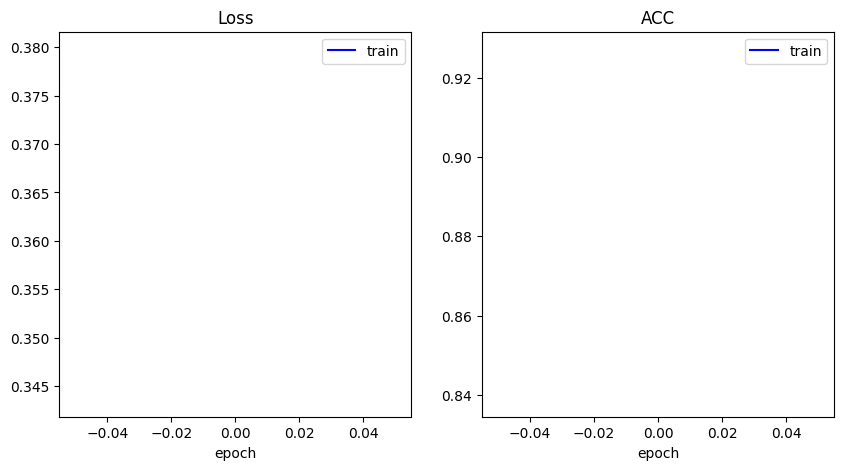

Epoch 1/3, Train Loss: 0.3617, Train Accuracy: 0.8830
train Loss: 0.3576,  ACC: 0.8856
train_metrics_logs[i] [0.8830379746835443, 0.8843881856540085]


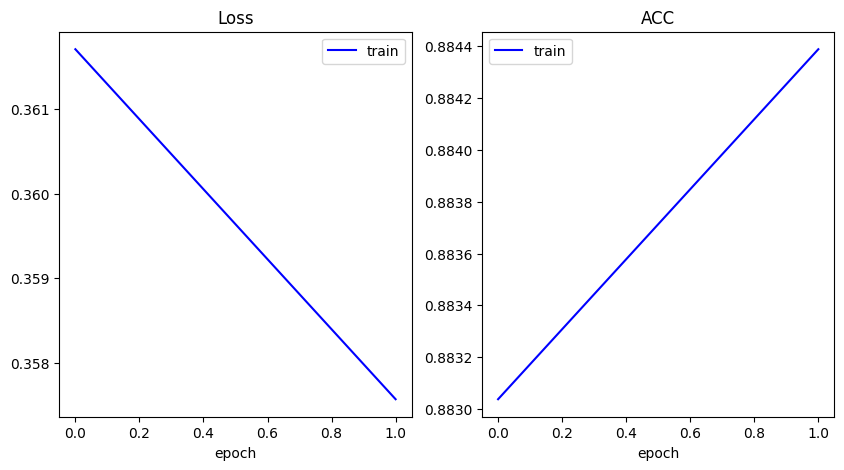

Epoch 2/3, Train Loss: 0.3576, Train Accuracy: 0.8844


In [ ]:

def train_model(model, train_loader, val_loader, metrics, num_epochs=1, learning_rate=0.001):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    model.to(device)

    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))
    
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]

    criterion = nn.BCELoss() # Binary cross-entropy loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i,batch in enumerate(train_loader):
            # print(f"Batch {i}")
            batch = [b.to(device) for b in batch]
            text, mask, img, labels = batch
            optimizer.zero_grad()
            outputs = model(text, mask)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            predicted = (outputs.detach() > 0.5)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * labels.size(0)
            # compute metrics
            # no gradients should be propagated at this step
            with torch.no_grad():
                for k in epoch_metrics.keys():
                    epoch_metrics[k] += metrics[k](predicted, labels)

        for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total

        train_metrics_log[0].append(train_accuracy)

        # clear_output() #clean the prints from previous epochs
        print('train Loss: {:.4f}, '.format(train_loss),
            ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))


        train_loss_log.append(train_loss)
        # train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, epoch_metrics)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in test_loader:
                batch = [b.to(device) for b in batch]
                text, mask, img, labels = batch
                outputs = model(text, mask)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * text.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct / total

        test_metrics_log[0].append(val_accuracy)

        plot_training(train_loss_log, metrics_names, train_metrics_log)

        # print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

def acc(preds, target):
    return accuracy_score(target.detach().cpu(), preds.detach().cpu())

metrics = {'ACC': acc}
# Example usage
train_model(model, train_loader, validation_loader, metrics, num_epochs=3, learning_rate=0.0001)


In [ ]:
# def train_model(model, train_loader, val_loader, num_epochs=1, learning_rate=0.001):
#     torch.cuda.empty_cache()
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     # device = torch.device("cpu")
#     model.to(device)

#     criterion = nn.BCELoss() # Binary cross-entropy loss
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0
#         for i,batch in enumerate(train_loader):
#             # print(f"Batch {i}")
#             batch = [b.to(device) for b in batch]
#             text, mask, labels = batch
#             optimizer.zero_grad()
#             outputs = model(text, mask)
#             loss = criterion(outputs, labels.float())
#             loss.backward()
#             optimizer.step()
#             predicted = (outputs.detach() > 0.5)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             running_loss += loss.item() * labels.size(0)
#         train_loss = running_loss / len(train_loader.dataset)
#         train_accuracy = correct / total

#         # # Validation phase
#         # model.eval()
#         # val_loss = 0.0
#         # correct = 0
#         # total = 0
#         # with torch.no_grad():
#         #     for batch in train_loader:
#         #         batch = [b.to(device) for b in batch]
#         #         text, mask, labels = batch
#         #         outputs = model(text, mask)
#         #         loss = criterion(outputs, labels.float())
#         #         val_loss += loss.item() * text.size(0)
#         #         _, predicted = torch.max(outputs.data, 1)
#         #         total += labels.size(0)
#         #         correct += (predicted == labels.sum().item())
#         # val_loss = val_loss / len(val_loader.dataset)
#         # val_accuracy = correct / total

#         print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
#         # print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# # Example usage
# train_model(model, train_loader, validation_loader, num_epochs=5, learning_rate=0.0001)


# step 4: Model evaluation

In [ ]:
# import torch
# import torch.nn as nn

# def evaluate_model(model, dataloader):
#     # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model.eval()

#     criterion = nn.CrossEntropyLoss()

#     total_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for images, input_ids, attention_mask, labels in tqdm(dataloader, desc='Evaluation'):
#             images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
#             outputs = model(images, input_ids, attention_mask)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item() * images.size(0)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     average_loss = total_loss / len(dataloader.dataset)
#     accuracy = correct / total

#     print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

# # Example usage
# evaluate_model(model, val_loader)


In [ ]:
torch.cuda.empty_cache()